# Simulated Annealing Demo

Skrypt przedstawia przykładową implementację algorytmu symulowanego wyżarzania (ang. Simulated Annealing, SA) i jego zastosowanie do rozwiązywania problemu Quadratic Assignment Problem (QAP). Problem jest dokładnie opisany m.in. w pracy Burkarda i innych [1]. Popularne instancje problemu QAP można znaleźć w bibliotece QAPLib [2]. Skrypt skupia się na rozwiązywaniu instancji NUG12 [3], w celu rozwiązywania innych instancji może okazać się konieczna zmiana ustawień parametrów algorytmu.

Literatura:

[1]  Burkard, R., Cela, E., Pardalos, P., Pitsoulis, L., "The Quadratic Assignment Problem", http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.217.1914

[2] QAPLIB, https://qaplib.mgi.polymtl.ca/

[3] NUG12, https://qaplib.mgi.polymtl.ca/data.d/nug12.dat

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import time
import urllib.request

%matplotlib inline

In [46]:
PROBLEM_NAME    = 'nug12'
PROBLEM_NAME_1  = 'nug15'
PROBLEM_NAME_2  = 'nug22'
PROBLEM_NAME_3  = 'nug28'


QAP_INSTANCE_URL    = f'https://qaplib.mgi.polymtl.ca/data.d/{PROBLEM_NAME}.dat'
QAP_INSTANCE_URL_1  = f'https://qaplib.mgi.polymtl.ca/data.d/{PROBLEM_NAME_1}.dat'
QAP_INSTANCE_URL_2  = f'https://qaplib.mgi.polymtl.ca/data.d/{PROBLEM_NAME_2}.dat'
QAP_INSTANCE_URL_3  = f'https://qaplib.mgi.polymtl.ca/data.d/{PROBLEM_NAME_3}.dat'

## Reading input data

In [47]:
def load_problem(qap_instance_file):
    line = qap_instance_file.readline()
    n = int(line.decode()[:-1].split()[0])
    print(f'Problem name: NUG {n}')
    print('Problem size: %d' % n)

    A = np.empty((n, n))
    qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        A[i, :] = list(map(int, line.decode()[:-1].split()))
    print(f'Flow matrix:\n{A}', end='\n\n')

    B = np.empty((n, n))
    qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        B[i, :] = list(map(int, line.decode()[:-1].split()))
    print(f'Distance matrix:\n{B}', end='\n\n')

    return A, B, n

In [48]:
qap_instance_file   = urllib.request.urlopen(QAP_INSTANCE_URL)
qap_instance_file_1 = urllib.request.urlopen(QAP_INSTANCE_URL_1)
qap_instance_file_2 = urllib.request.urlopen(QAP_INSTANCE_URL_2)
qap_instance_file_3 = urllib.request.urlopen(QAP_INSTANCE_URL_3)

A,  B,  size   = load_problem(qap_instance_file)
A1, B1, size1  = load_problem(qap_instance_file_1)
A2, B2, size2  = load_problem(qap_instance_file_2)
A3, B3, size3  = load_problem(qap_instance_file_3)

Problem name: NUG 12
Problem size: 12
Flow matrix:
[[0. 1. 2. 3. 1. 2. 3. 4. 2. 3. 4. 5.]
 [1. 0. 1. 2. 2. 1. 2. 3. 3. 2. 3. 4.]
 [2. 1. 0. 1. 3. 2. 1. 2. 4. 3. 2. 3.]
 [3. 2. 1. 0. 4. 3. 2. 1. 5. 4. 3. 2.]
 [1. 2. 3. 4. 0. 1. 2. 3. 1. 2. 3. 4.]
 [2. 1. 2. 3. 1. 0. 1. 2. 2. 1. 2. 3.]
 [3. 2. 1. 2. 2. 1. 0. 1. 3. 2. 1. 2.]
 [4. 3. 2. 1. 3. 2. 1. 0. 4. 3. 2. 1.]
 [2. 3. 4. 5. 1. 2. 3. 4. 0. 1. 2. 3.]
 [3. 2. 3. 4. 2. 1. 2. 3. 1. 0. 1. 2.]
 [4. 3. 2. 3. 3. 2. 1. 2. 2. 1. 0. 1.]
 [5. 4. 3. 2. 4. 3. 2. 1. 3. 2. 1. 0.]]

Distance matrix:
[[ 0.  5.  2.  4.  1.  0.  0.  6.  2.  1.  1.  1.]
 [ 5.  0.  3.  0.  2.  2.  2.  0.  4.  5.  0.  0.]
 [ 2.  3.  0.  0.  0.  0.  0.  5.  5.  2.  2.  2.]
 [ 4.  0.  0.  0.  5.  2.  2. 10.  0.  0.  5.  5.]
 [ 1.  2.  0.  5.  0. 10.  0.  0.  0.  5.  1.  1.]
 [ 0.  2.  0.  2. 10.  0.  5.  1.  1.  5.  4.  0.]
 [ 0.  2.  0.  2.  0.  5.  0. 10.  5.  2.  3.  3.]
 [ 6.  0.  5. 10.  0.  1. 10.  0.  0.  0.  5.  0.]
 [ 2.  4.  5.  0.  0.  1.  5.  0.  0.  0. 10. 10.]
 [ 

## Objective function

In [49]:
def qap_objective_function(p, A=A, B=B):
    s = 0.0
    n = len(p)
    for i in range(n):
        s += (A[i, :] * B[p[i], p]).sum()
    return s

In [50]:
p = [11, 6, 8, 2, 3, 7, 10, 0, 4, 5, 9, 1]
print(qap_objective_function(p), p)

578.0 [11, 6, 8, 2, 3, 7, 10, 0, 4, 5, 9, 1]


## Random Sampling

In [56]:
def random_sampling(size: int = size, A = A, B = B, T: int = 1000000):
    t0 = time.time()

    permutations = np.empty((T, size), dtype=np.int64)

    costs = np.zeros(T)
    for i in range(T):
        permutations[i, :] = np.random.permutation(size)
        costs[i] = qap_objective_function(permutations[i, :], A, B)

    print(f'{time.time() - t0:.2f} s')

    p = permutations[costs.argmin(), :]
    print(qap_objective_function(p, A, B), p)

    return p, costs, np.argmin(costs)

29.56 s
1212.0 [ 1  8 12 13 14  0  7  2  4  5  3 10  6 11  9]
43.27 s
4064.0 [ 7 18 17 19  0  6 15  9  5 11 16  3 13  2 20  8 10 21 12  1  4 14]
54.21 s
6014.0 [21 20 12 26 13  3 16 18  9  4 23  1  2  5 24 17 22 11  7 19 10 15  8  0
 14 25 27  6]
24.08 s
606.0 [ 5  4  1  9  6 10  8 11  7  3  0  2]


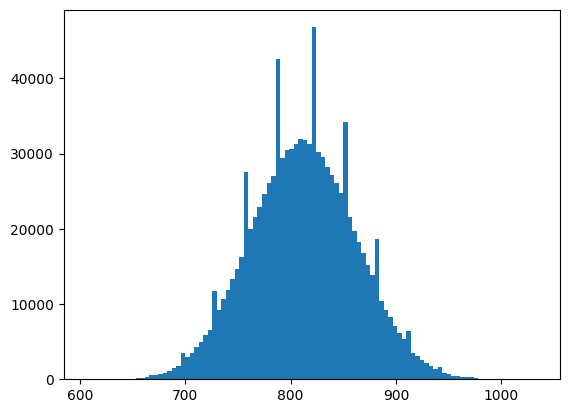

812.033796 49.76586004310971


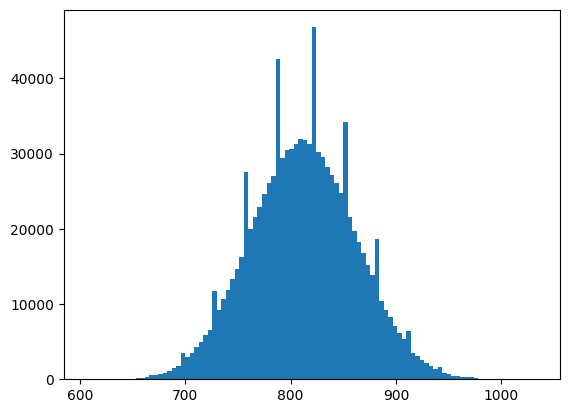

812.033796 49.76586004310971


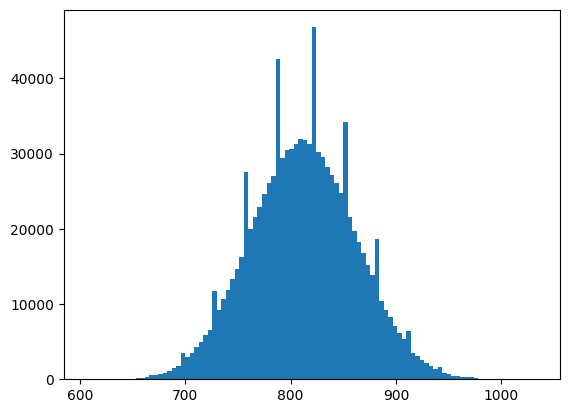

812.033796 49.76586004310971


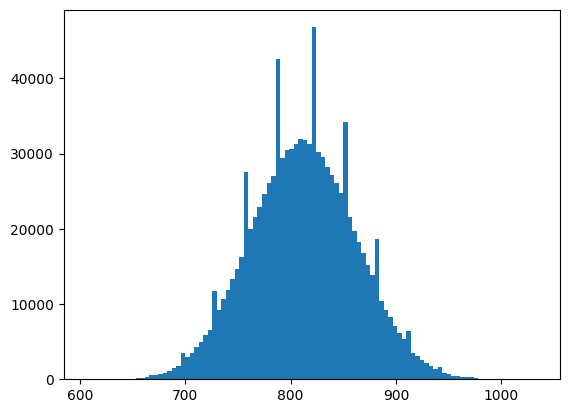

812.033796 49.76586004310971


In [ ]:
best_p,  costs,  min_cost  = random_sampling(size, A, B)
best_p1, costs1, min_cost1 = random_sampling(size1, A1, B1)
best_p2, costs2, min_cost2 = random_sampling(size2, A2, B2)
best_p3, costs3, min_cost3 = random_sampling(size3, A3, B3)

all_costs = [costs, costs1, costs2, costs3]

for costs in all_costs:
    plt.figure()
    plt.hist(costs, bins=100)
    plt.show()
    print(costs.mean(), costs.std())

## Simulated Annealing

In [ ]:
def random_neighbor(size, p, radius):
    q = p.copy()
    for r in range(radius):
        i, j = np.random.choice(size, 2, replace=False)
        q[i], q[j] = q[j], q[i]
    return q

In [66]:
def simulated_annealing(size: int = size, A = A, B = B, alpha: float = 1.0, radius: int = 1 , T: int = 500000):
    t0 = time.time()

    p = np.random.permutation(size)
    best_permutation = p
    p_cost = qap_objective_function(p, A, B)
    costs = np.zeros(T)
    for t in range(T):
        q = random_neighbor(size, p, radius)
        q_cost = qap_objective_function(q, A, B)
        if(q_cost < p_cost):
            p, p_cost = q, q_cost
            best_permutation = q
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
        costs[t] = p_cost

    print(time.time() - t0)
    print(best_permutation, np.min(costs))

    return best_permutation, costs, np.min(costs)

32.076377153396606
[18 13  1  0 20 10 11  9  4 25 15 26 12 14 21  8 27 16  2  7  6 17 23 19
  5 24 22  3] 5286.0


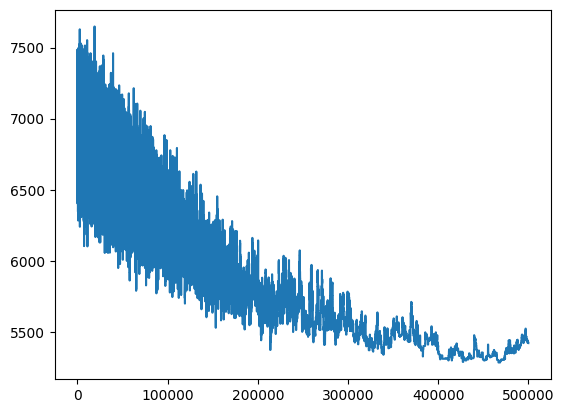

32.60420513153076
[23  1  4 20  0 15 16 25  2  9 18 14  8 13 19 12 22 10 24  6  3 17 11 21
 26  7  5 27] 5234.0


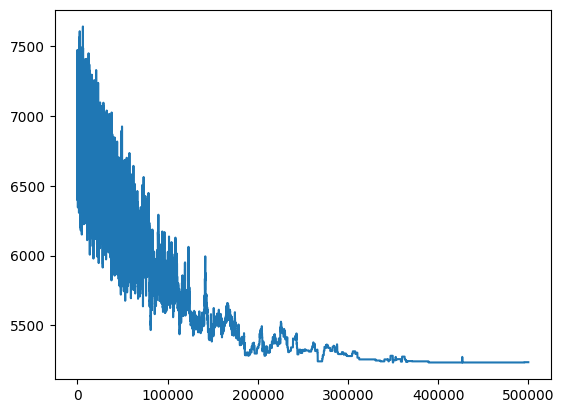

32.5445659160614
[25  6  2  0 13 12 11  9  4 18 16 19  5 21 22  1 27 24 10 14  3 17 23 26
  8 20 15  7] 5192.0


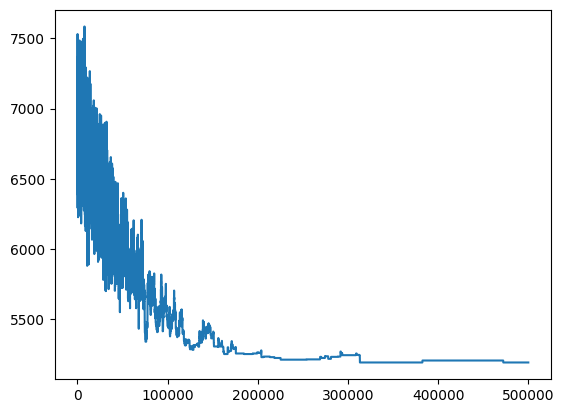

33.03829503059387
[ 2 22 25 20 21 14 10  5 16  9 12  8 15 27  6 17  0 18  4 26 23 11 19  1
  3  7 13 24] 5226.0


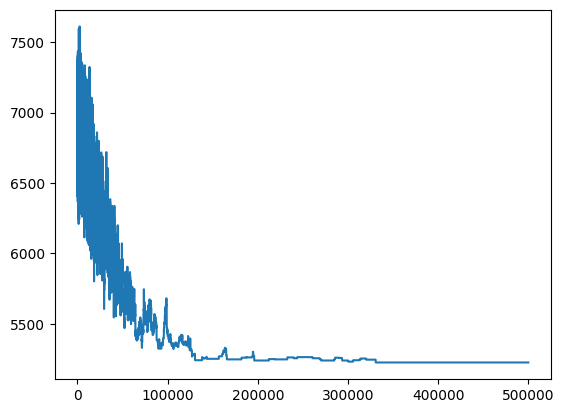

32.88373398780823
[24 14 12  6 21 15 10  4  8  9 11 16  7 20 27  5 25 19  3 26  0 17 18 23
  2 22 13  1] 5178.0


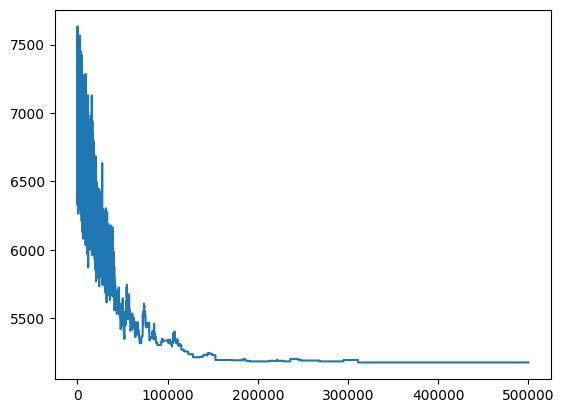

32.81718397140503
[19 14  8  1 21 25 17  9 10 18  4 26 24  0  6  3 20 12 16  7 15 11  5 27
 23 13  2 22] 5254.0


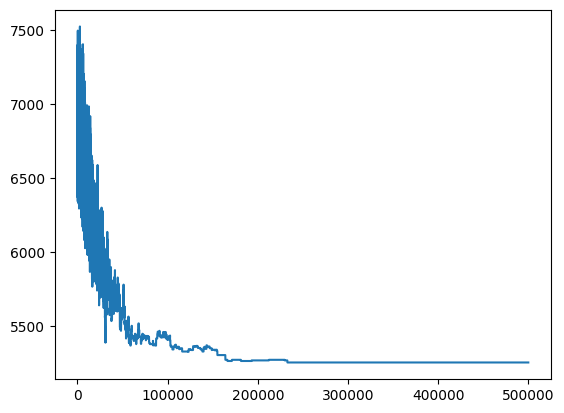

32.60636305809021
[25  5  2  0  6 12 17 16  3 11 10 19  4 21 20  8 27 23 22 14  1 18 24 26
 15 13  9  7] 5228.0


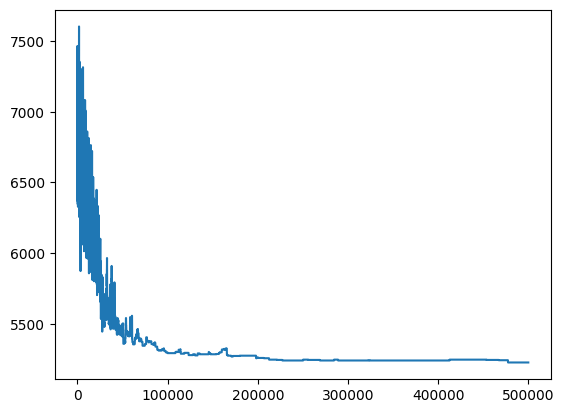

31.996901750564575
[ 9 13 12  5  6  7 17 24 18 16  3 14 15 26  0 25  1 11 23 27 20 10  4  8
 22  2 19 21] 5242.0


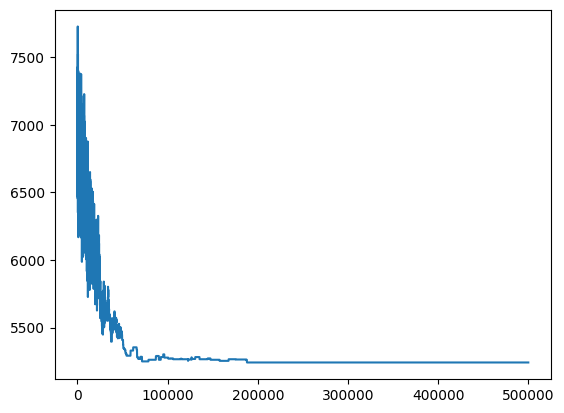

32.90777397155762
[12 26 23  0 27 18 10  9 24  4  3 19 25 14  6  1 13 16  8 15 22 11 17 20
  7  5  2 21] 5248.0


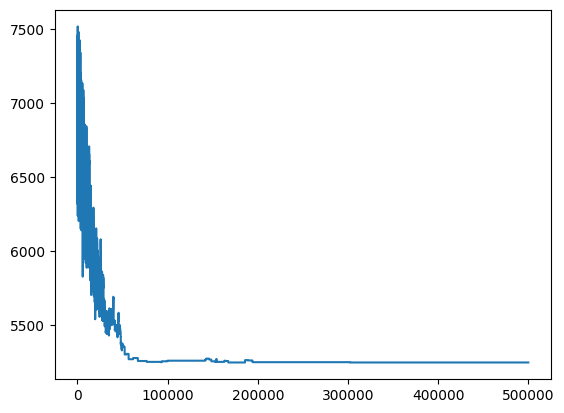

32.57940220832825
[ 3 21 19 27 14 16 10 18  7  8 12  9 15 26  6 20  1  5 17 25 22 11  4  2
 24  0 13 23] 5272.0


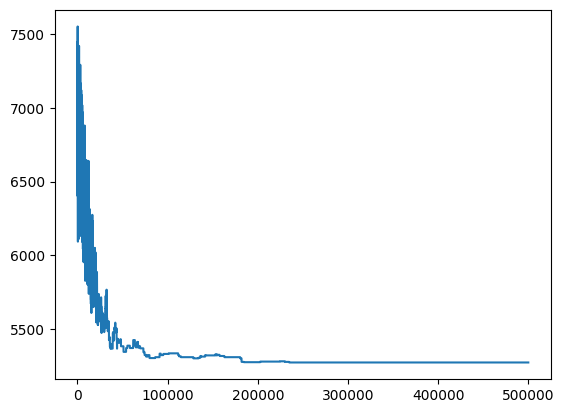

32.86732292175293
[25  6  2  0 13 12 11  9  4 18 16 19  5 21 22  1 27 24 10 14  3 17 23 26
  8 20 15  7] 5192.0


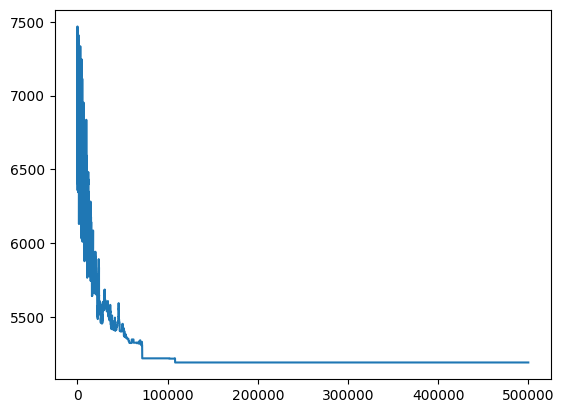

32.5439817905426
[ 1  5 12 26  6  3  9 16 11  8 23  2  4 27 21 25 14 18 15 20 13 10 17  0
 22  7 19 24] 5252.0


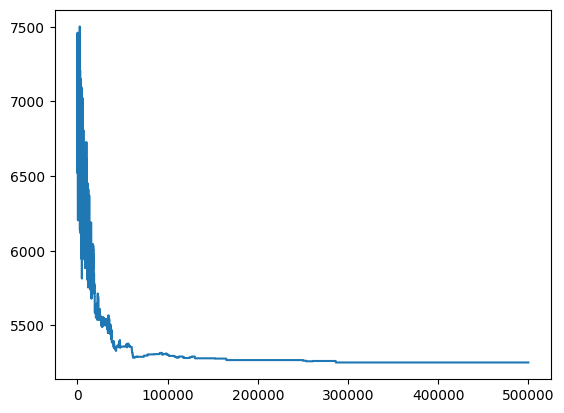

KeyboardInterrupt: 

In [79]:
for a in np.linspace(0.1, 2, num=20):
    for r in np.linspace(1, 5, num=5):
        print(f'alpha: {a} | radius: {r}')
        best_perm,  costs,  min_cost  = simulated_annealing(size3, A3, B3, alpha=a, radius=2)

    plt.figure()
    plt.plot(costs)
    plt.show()

14.895747184753418
[ 4  5  3 11  9  6 10  8  1  0  7  2] 578.0
17.489238023757935
[10  7  6 11  9  8 12  2  4 14  0  1  3 13  5] 1152.0
26.93938899040222
[16  7 18 10  6  9 15  8  3 13 19 14  0 17 21  5 11 12  2 20  1  4] 3658.0
31.724467039108276
[24 13  2  1  6 11 17 15 19 18  9 25 12  0 21  8 27  3 16 14  5 10  4 26
 23 20  7 22] 5226.0


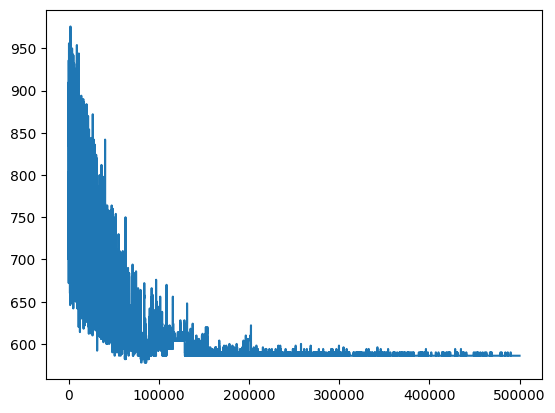

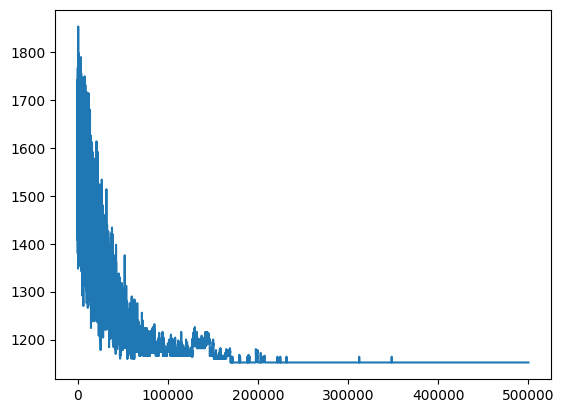

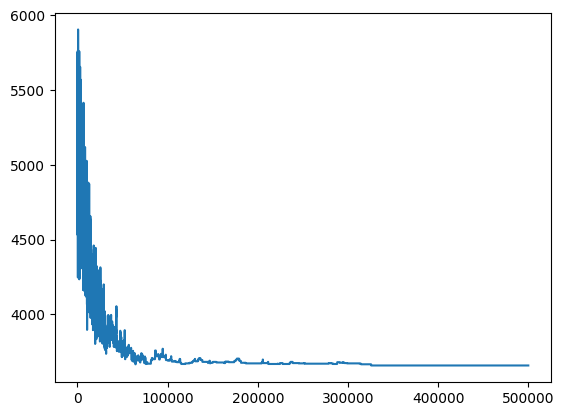

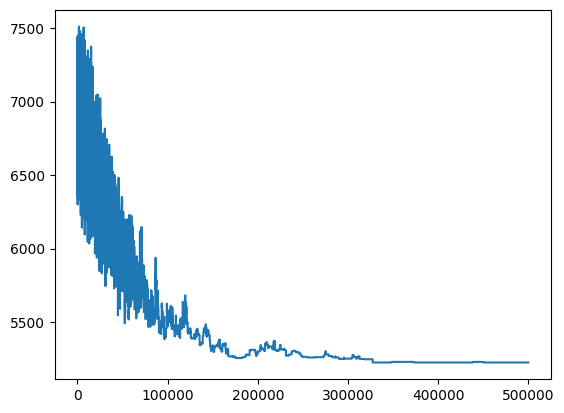

In [ ]:
best_perm,  costs,  min_cost  = simulated_annealing(size,  A,  B,  alpha=1.0, radius=1)
best_perm1, costs1, min_cost1 = simulated_annealing(size1, A1, B1, alpha=1.0, radius=1)
best_perm2, costs2, min_cost2 = simulated_annealing(size2, A2, B2, alpha=0.75, radius=2)
best_perm3, costs3, min_cost3 = simulated_annealing(size3, A3, B3, alpha=0.4, radius=2)

all_costs = [costs, costs1, costs2, costs3]

for costs in all_costs:
    plt.figure()
    plt.plot(costs)
    plt.show()

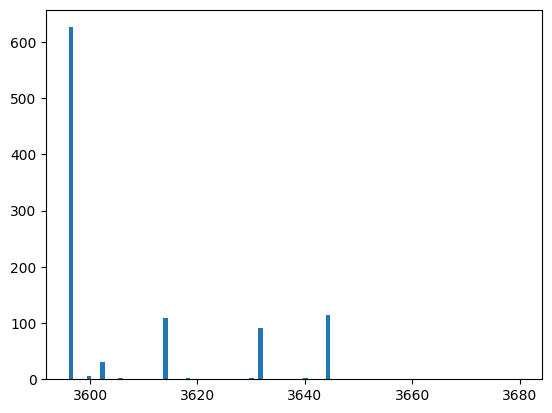

3607.798 17.859092810106567


In [92]:
def simulated_annealing_raw(size: int = size, A = A, B = B, alpha: float = 1.0, radius: int = 1, T: int = 500000):
    p = np.random.permutation(size)
    best_permutation = p
    p_cost = qap_objective_function(p, A, B)
    costs = np.zeros(T)
    for t in range(T):
        q = random_neighbor(size, p, radius)
        q_cost = qap_objective_function(q, A, B)
        if(q_cost < p_cost):
            p, p_cost = q, q_cost
            best_permutation = q
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
        costs[t] = p_cost

    return best_permutation, costs, np.min(costs)

def run_many_sa(runs: int = 1000):
    res = np.zeros(runs)
    for i in range(runs):
        _, _, mc = simulated_annealing_raw(size2, A2, B2, alpha=1.0, radius=1) 
        res[i] = mc

    return res

res = run_many_sa(runs=1000)

plt.figure()
plt.hist(res, bins=100)
plt.show()
print(res.mean(), res.std())

# Sucesy i porazki akceptowalne

In [94]:
def simulated_annealing_sl(size: int = size, A = A, B = B, alpha: float = 1.0, radius: int = 1, T: int = 500000):
    succ = 0
    loss = 0
    window_s = []
    window_l = []
    p = np.random.permutation(size)
    best_permutation = p
    p_cost = qap_objective_function(p, A, B)
    costs = np.zeros(T)
    for t in range(T):
        q = random_neighbor(size, p, radius)
        q_cost = qap_objective_function(q, A, B)
        if(q_cost < p_cost):
            p, p_cost = q, q_cost
            best_permutation = q
            succ += 1
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
            loss += 1
        costs[t] = p_cost

        window_s.append(succ)

        window_l.append(loss)

    return window_s, window_l

succ, loss = simulated_annealing_sl(alpha=10.0, radius=2)


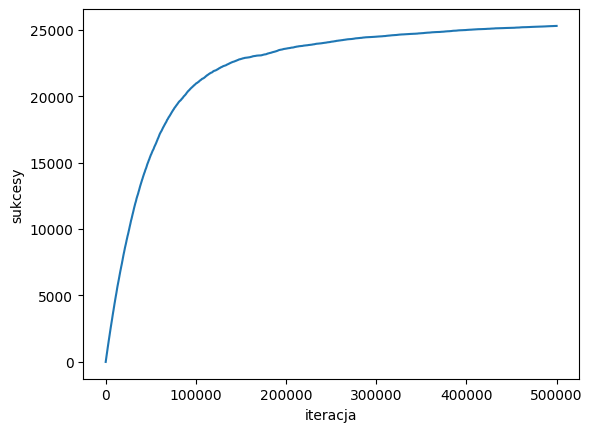

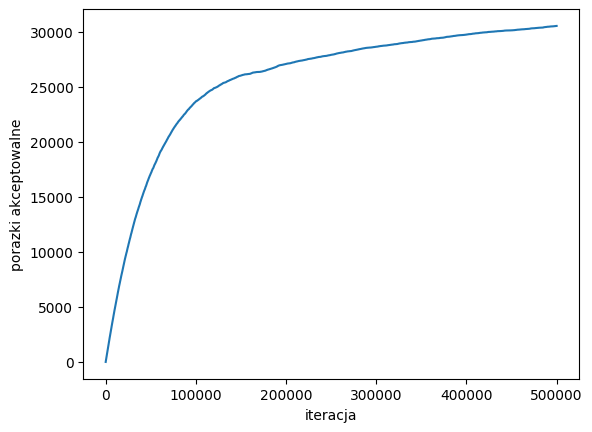

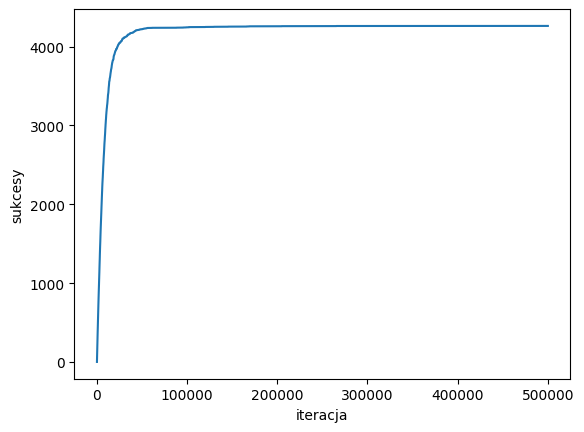

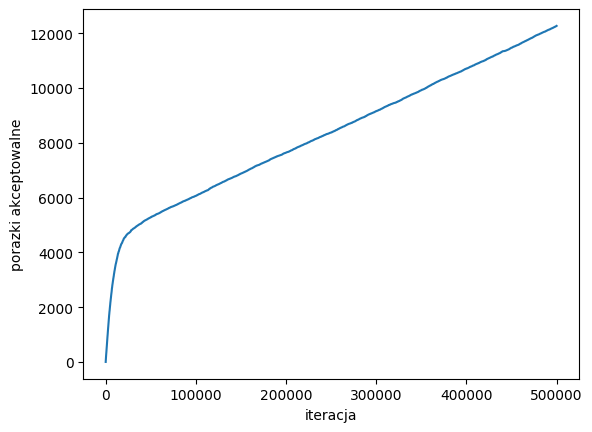

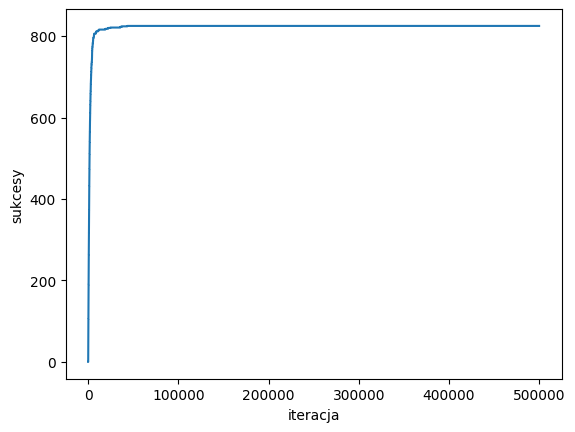

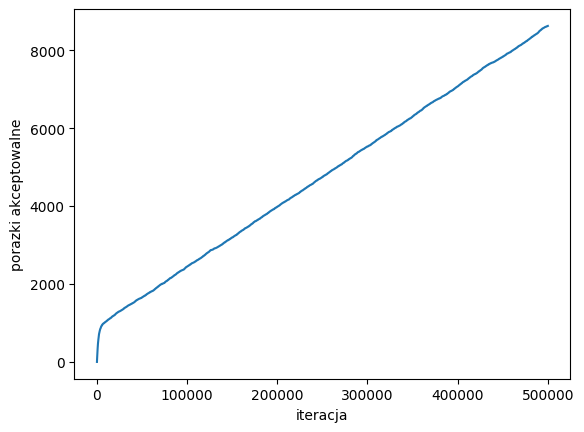

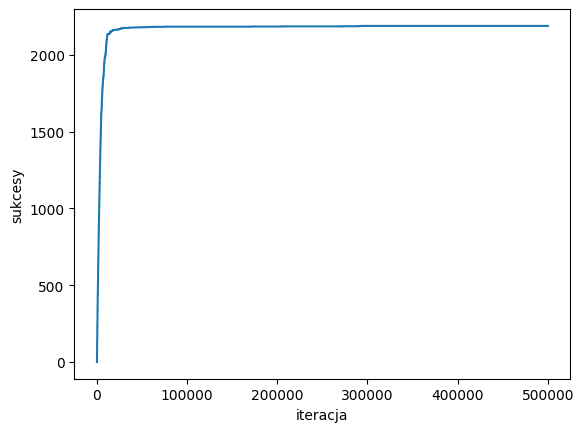

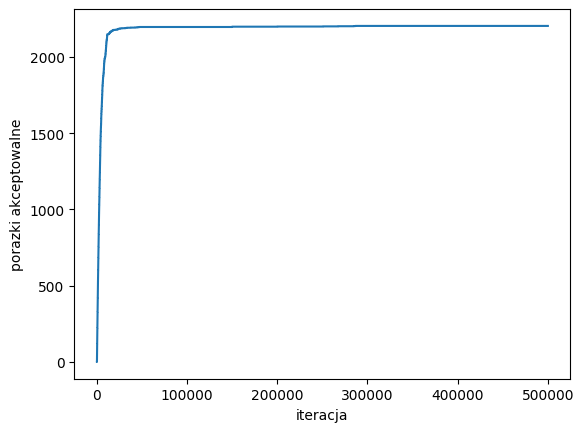

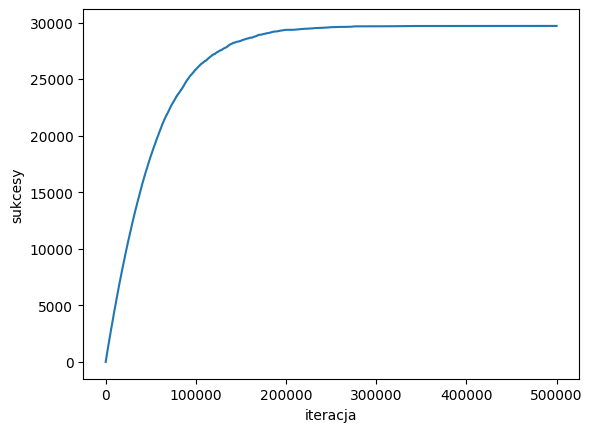

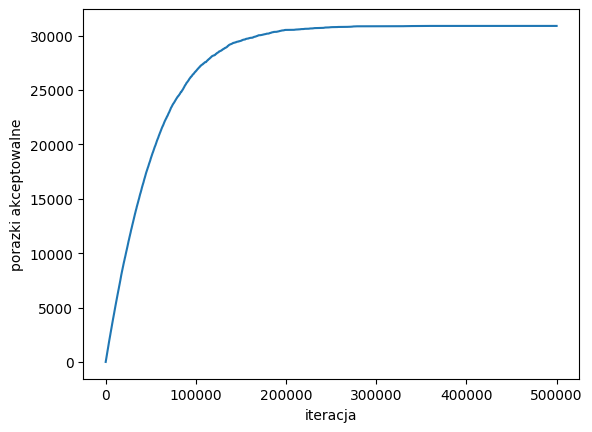

In [100]:
params = [
    {"alpha": 0.5, "radius": 1},
    {"alpha": 2.0, "radius": 2},
    {"alpha": 10.0, "radius": 2},
    {"alpha": 3.0, "radius": 5},
    {"alpha": 0.20, "radius": 10},
]

T = [i for i in range(1, 500001)]

for param in params:
    succ, loss = simulated_annealing_sl(alpha=param['alpha'], radius=param['radius'])

    plt.figure()
    plt.plot(succ)
    plt.xlabel('iteracja')
    plt.ylabel('sukcesy')
    plt.show()

    plt.figure()
    plt.plot(loss)
    plt.xlabel('iteracja')
    plt.ylabel('porazki akceptowalne')
    plt.show()

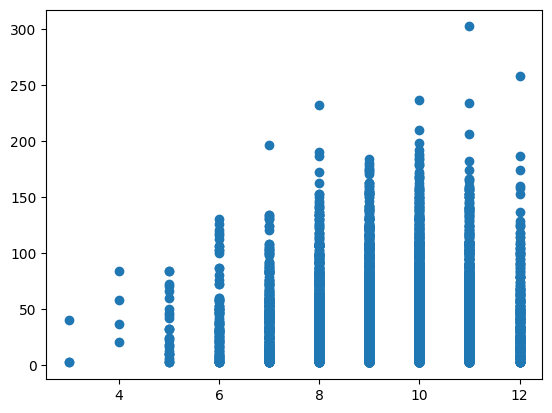

In [103]:
def simulated_annealing_diff(size: int = size, A = A, B = B, alpha: float = 1.0, radius: int = 1, T: int = 500000):
    f_diff = []
    l_diff = []
    p = np.random.permutation(size)
    best_permutation = p
    p_cost = qap_objective_function(p, A, B)
    costs = np.zeros(T)
    for t in range(T):
        q = random_neighbor(size, p, radius)
        q_cost = qap_objective_function(q, A, B)
        if(q_cost < p_cost):
            f_diff.append(p_cost - q_cost)
            l_diff.append(np.sum(p != q))
            p, p_cost = q, q_cost
            best_permutation = q
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
        costs[t] = p_cost

    return f_diff, l_diff

f_diff, l_diff = simulated_annealing_diff(radius=10)

plt.figure()
plt.scatter(x=l_diff, y=f_diff)
plt.show()



In [ ]:
def simulated_annealing(size: int = size, A = A, B = B, alpha: float = 1.0, radius: int = 1 , T: int = 500000):
    t0 = time.time()

    p = np.random.permutation(size)
    best_permutation = p
    p_cost = qap_objective_function(p, A, B)
    costs = np.zeros(T)
    for t in range(T):
        q = random_neighbor(size, p, radius)
        q_cost = qap_objective_function(q, A, B)
        if(q_cost < p_cost):
            p, p_cost = q, q_cost
            best_permutation = q
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
        costs[t] = p_cost

    print(time.time() - t0)
    print(best_permutation, np.min(costs))

    return best_permutation, costs, np.min(costs)